In [ ]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:

def scale(arr):
    arr = arr.astype(np.float32)
    if arr.ndim == 4:
        for i in range(len(arr)):
            arr[i,:,:,:] =  (arr[i,:,:,:] - arr[i,:,:,:].min())/ (arr[i,:,:,:].max() - arr[i,:,:,:].min() + 1e-6)
    elif arr.ndim ==3:
        arr[:,:,:] =  (arr[:,:,:] - arr[:,:,:].min())/ (arr[:,:,:].max() - arr[:,:,:].min() + 1e-6)
    else :
        raise Exception("Unknown dimension array provided, expected 3 or 4, got", arr.ndim)
    return arr


def get_RGB(S1, S2):
    blue_c = S1[:,:,:,0] - S1[:,:,:,1]
    blue_c = blue_c[:,:,:,np.newaxis]
    S1_rgb = np.concatenate([S1,blue_c], axis=3)
    S2_rgb = S2[:,:,:,:3]
    return S1_rgb, S2_rgb



def show_preds(S1,S2,S1_pred,S2_pred,epoch, save=True):
    for i in range(len(S1)):
        # plt.figure(figsize=(10,8))
        fig, ax = plt.subplots(nrows=1, ncols=4,figsize= (16,12))
        # plt.subplot(1,4,1)
        ax[0].imshow(scale(S1)[i])
        ax[0].set_title('Original S1')

        ax[1].imshow(scale(S1_pred)[i])
        ax[1].set_title('Generated S1')
        # plt.subplot(1,4,2)
        ax[2].imshow(scale(S2_pred)[i])
        ax[2].set_title('Generated S2')
        # plt.subplot(1,4,3)
        ax[3].imshow(scale(S2)[i])
        ax[3].set_title('Original S2')
        # plt.subplot(1,4,4)
        fig.tight_layout()
        #Save this fig
        if save:
            fig.savefig(f"/content/drive/MyDrive/Flood_Monitoring/CycleGAN2/Pred_Epoch{epoch}_{i}.png")
        plt.show()


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Flood_Monitoring/Cloud2Street/chips"
OUT_PATH = "/content/drive/MyDrive/Flood_Monitoring/Cloud2Street/outputs"

In [ ]:
cloud2Street_data = torch.load(os.path.join(OUT_PATH,"Cloud2Street_dataset.pt"))
S1_images = cloud2Street_data["S1_images"]
S2_images = cloud2Street_data["S2_images"]
S2_clouds = cloud2Street_data["S2_clouds"]
S2_water = cloud2Street_data["S2_water"]
S1_images.shape, S2_images.shape, S2_water.shape

((900, 512, 512, 2), (900, 512, 512, 4), (900, 512, 512))

In [ ]:
cloud2Street_data.keys()

dict_keys(['S1_images', 'S2_images', 'S2_clouds', 'S2_water', 'S1_paths', 'S2_paths'])

In [ ]:
def NDWI(arr):
    if arr.ndim == 4:
        return (arr[:,:,:,0] - arr[:,:,:,1])/(arr[:,:,:,0] + arr[:,:,:,1] + 1e-6)
    elif arr.ndim ==3:
        return (arr[:,:,0] - arr[:,:,1])/(arr[:,:,0] + arr[:,:,1] + 1e-6)
    else :
        raise Exception("Unknown dimension array provided, expected 3 or 4, got", arr.ndim)

def scale(arr):
    arr = arr.astype(np.float32)
    if arr.ndim == 4:
        for i in range(len(arr)):
            arr[i,:,:,:] =  (arr[i,:,:,:] - arr[i,:,:,:].min())/ (arr[i,:,:,:].max() - arr[i,:,:,:].min() + 1e-6)
    elif arr.ndim ==3:
        arr[:,:,:] =  (arr[:,:,:] - arr[:,:,:].min())/ (arr[:,:,:].max() - arr[:,:,:].min() + 1e-6)
    else :
        raise Exception("Unknown dimension array provided, expected 3 or 4, got", arr.ndim)
    return arr
def tile(im, M, N):
    return np.array([im[x:x+M,y:y+N,:] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)])

In [ ]:
# S2_NDWI = NDWI(scale(S2_images[:,:,:,1]),scale(S2_images[:,:,:,3]))[:,:,:,None]
S2_NDWI = scale(S2_images[:,:,:,[1,3]])

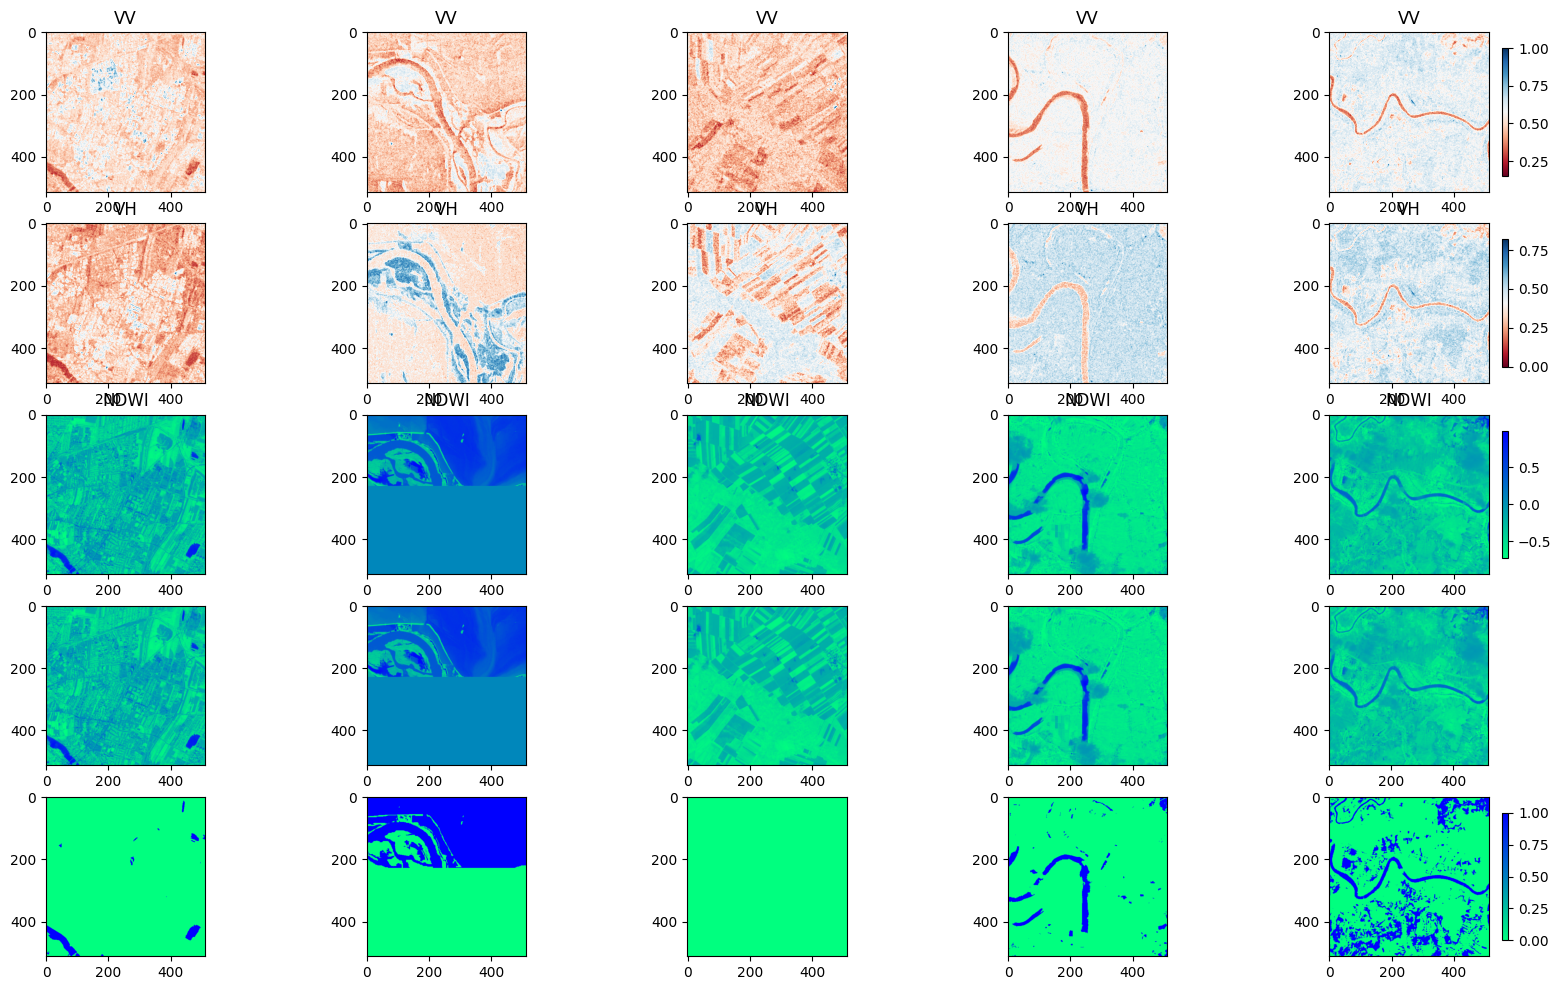

In [ ]:
n_samples = np.random.choice(S1_images.shape[0], 5, replace=False)
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(20,12))

for i in range(len(n_samples)):
    c1 = ax[0,i].imshow(scale(S1_images[n_samples[i]])[:,:,0],cmap="RdBu")
    c2 = ax[1,i].imshow(scale(S1_images[n_samples[i]])[:,:,1],cmap="RdBu")
    c3 = ax[2,i].imshow(NDWI(S2_NDWI[n_samples[i]]) ,cmap="winter_r")
    # ax[3,i].imshow(scale(S2_images[n_samples[i],:,:,:3]))
    ax[3,i].imshow(scale(NDWI(S2_NDWI[n_samples[i]][:,:,None])) ,cmap="winter_r")
    c4 = ax[4,i].imshow(S2_water[n_samples[i]],cmap="winter_r")

    ax[0,i].set_title("VV")
    ax[1,i].set_title("VH")
    ax[2,i].set_title("NDWI")
plt.colorbar(c1,ax = ax[0,4],shrink = 0.8)
plt.colorbar(c2,ax = ax[1,4],shrink = 0.8)
plt.colorbar(c3,ax = ax[2,4],shrink = 0.8)
plt.colorbar(c4,ax = ax[4,4],shrink = 0.8);

In [ ]:
tile_size = 128
S1_tiles = [tile(im, tile_size, tile_size) for im in S1_images]
S2_tiles = [tile(im, tile_size, tile_size) for im in S2_NDWI]
S2_cloud_tiles = [tile(im, tile_size, tile_size) for im in S2_clouds[:,:,:,None]]
S1_tiles = np.vstack(S1_tiles)
S2_tiles = np.vstack(S2_tiles)
S2_cloud_tiles = np.vstack(S2_cloud_tiles)
cloud_PCT = (S2_cloud_tiles.sum(axis=(1,2))/(tile_size* tile_size)).squeeze()

In [ ]:
import numpy as np
from skimage.filters import threshold_otsu

def ndwi_to_binary(ndwi_array):
    """
    Convert NDWI array to a binary mask using Otsu's thresholding method.

    Parameters:
    ndwi_array (numpy.ndarray): The NDWI array.

    Returns:
    numpy.ndarray: Binary mask based on the optimal threshold.
    """
    # Ensure the NDWI array is scaled between 0 and 1
    ndwi_scaled = (ndwi_array - ndwi_array.min()) / (ndwi_array.max() - ndwi_array.min())

    # Compute the optimal threshold using Otsu's method
    optimal_threshold = threshold_otsu(ndwi_scaled)

    # Create a binary mask based on the threshold
    binary_mask = ndwi_scaled > optimal_threshold

    return binary_mask

In [ ]:
S1_filtered = S1_tiles[cloud_PCT == 0]
S2_filtered = S2_tiles[cloud_PCT == 0]
S1_filtered.shape, S2_filtered.shape

S1_filtered = scale(S1_filtered)
S2_filtered = ndwi_to_binary(scale(NDWI(scale(S2_filtered)))).astype(np.uint8)[:,:,:,None]

S1_train, S1_test, S2_train, S2_test = train_test_split(S1_filtered, S2_filtered, test_size=0.2, random_state=47)

# S1_train  = np.array([tf.cast((img*2) - 1.0, tf.float32) for img in S1_train])
# S2_train  = np.array([tf.cast((img*2) - 1.0, tf.float32) for img in S2_train])

dataset = [S1_train, S2_train]

In [ ]:
S1_cloud = S1_tiles[cloud_PCT == 1]
S2_cloud = S2_tiles[cloud_PCT == 1]

In [ ]:
S1_cloud = scale(S1_cloud)
S2_cloud = ndwi_to_binary(scale(NDWI(scale(S2_cloud)))).astype(np.uint8)[:,:,:,None]

In [ ]:
# for i in range(20):
#   plt.imshow(S2_cloud[i], cmap="winter_r")
#   plt.show()

In [ ]:
S1_filtered.shape, S2_filtered.shape

((7878, 128, 128, 2), (7878, 128, 128, 1))

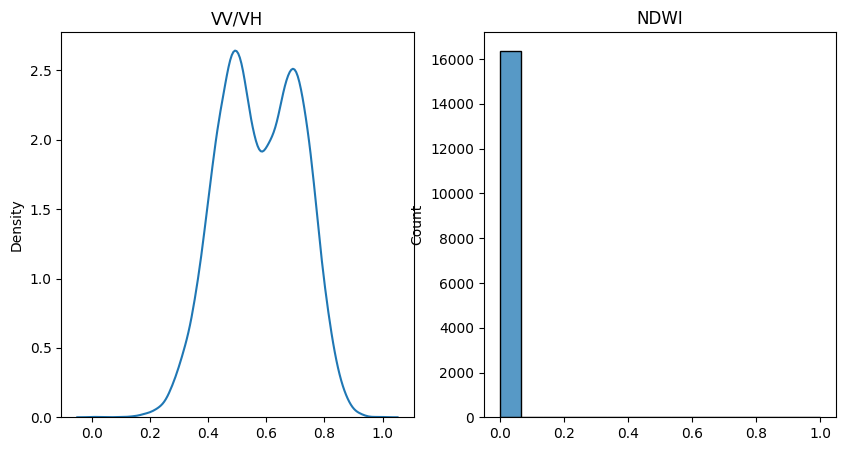

In [ ]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
sns.kdeplot(S1_train[10].flatten(),ax=ax[0]).set_title("VV/VH")
sns.histplot(S2_train[10].flatten(),ax=ax[1]).set_title("NDWI");

In [ ]:
# sample_idx = np.random.randint(0,S1_train.shape[0],5)
# gen_out = g(S1_train[sample_idx])
# gen_out = gen_out.numpy()

# fig, ax = plt.subplots(nrows=4, ncols=5,figsize=(20,12))
# for i,j in enumerate(sample_idx):
#     c1 = ax[0,i].imshow(scale(S1_train[j])[:,:,0],cmap="RdBu")
#     c2 = ax[1,i].imshow(scale(S1_train[j])[:,:,1],cmap="RdBu")
#     c3 = ax[2,i].imshow(scale(NDWI(scale(S2_train[j]))[:,:,None]),cmap="winter_r")
#     c4 = ax[3,i].imshow(scale(NDWI(scale(gen_out[i]))[:,:,None]),cmap="winter_r")
#     ax[0,i].set_title("VV")
#     ax[1,i].set_title("VH")
#     ax[2,i].set_title("NDWI")
#     ax[3,i].set_title("Generated NDWI")
#     ax[0,i].axis("off")
#     ax[1,i].axis("off")
#     ax[2,i].axis("off")
#     ax[3,i].axis("off")
# plt.colorbar(c1,ax = ax[0,4],shrink = 0.8)
# plt.colorbar(c2,ax = ax[1,4],shrink = 0.8)
# plt.colorbar(c3,ax = ax[2,4],shrink = 0.8)
# plt.colorbar(c4,ax = ax[3,4],shrink = 0.8);
# fig.savefig(f"/content/drive/MyDrive/SrJ/Flood_Monitoring/CycleGAN2/Sample_Epoch100000_NoThresh.png")

#Trying UNet


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [ ]:
S1_train, S2_train = augment(S1_train, S2_train)

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [ ]:

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:

def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,2))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(1, 3, padding="same", activation = "sigmoid", kernel_initializer="he_normal")(u9)
#    outputs = u9
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
S1_train.shape, S2_train.shape, S1_test.shape, S2_test.shape

((6302, 128, 128, 2),
 (6302, 128, 128, 1),
 (1576, 128, 128, 2),
 (1576, 128, 128, 1))

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())


In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="binary_crossentropy",
                   metrics=['accuracy', keras.metrics.AUC(),r2_score,tf.keras.metrics.MeanIoU(num_classes=2)])            #,tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
# def iou_loss(y_true, y_pred):
#     y_true = tf.cast(y_true, dtype=tf.float32)
#     y_pred = tf.cast(y_pred, dtype=tf.float32)

#     intersection = K.sum(y_true * y_pred)
#     sum_ = K.sum(y_true + y_pred)
#     jac = (intersection + 1.0) / (sum_ - intersection + 1.0)
#     return 1 - jac

# unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=iou_loss,
#                    metrics=['accuracy', tf.keras.metrics.AUC(), r2_score])


In [ ]:
EPOCHS = 40
BATCH_SIZE = 64
STEPS_PER_BATCH = len(S1_train) // BATCH_SIZE
VAL_STEPS = len(S1_test) // BATCH_SIZE

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(os.path.join(OUT_PATH,"U-Net","best_model_unet_mutli_threshold.hdf5"), monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = unet_model.fit(S1_train, S2_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          validation_data=(S1_test, S2_test), callbacks=[checkpoint],
                         class_weight = {0:1, 1:2})

Epoch 1/40
99/99 [==============================] - ETA: 0s - loss: 0.7033 - accuracy: 0.8253 - auc: 0.5752 - r2_score: -0.1477 - mean_io_u: 0.4150

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 189s 1s/step - loss: 0.7033 - accuracy: 0.8253 - auc: 0.5752 - r2_score: -0.1477 - mean_io_u: 0.4150 - val_loss: 0.5125 - val_accuracy: 0.8149 - val_auc: 0.6926 - val_r2_score: -0.1845 - val_mean_io_u: 0.4124
Epoch 2/40
99/99 [==============================] - 105s 1s/step - loss: 0.6704 - accuracy: 0.8211 - auc: 0.6462 - r2_score: -0.0916 - mean_io_u: 0.4150 - val_loss: 0.4508 - val_accuracy: 0.8227 - val_auc: 0.6957 - val_r2_score: 0.0086 - val_mean_io_u: 0.4124
Epoch 3/40
99/99 [==============================] - 105s 1s/step - loss: 0.6534 - accuracy: 0.8185 - auc: 0.6785 - r2_score: -0.0604 - mean_io_u: 0.4150 - val_loss: 0.4318 - val_accuracy: 0.8241 - val_auc: 0.7202 - val_r2_score: 0.0522 - val_mean_io_u: 0.4124
Epoch 4/40
99/99 [==============================] - 103s 1s/step - loss: 0.6414 - accuracy: 0.8237 - auc: 0.6942 - r2_score: -0.0260 - mean_io_u: 0.4150 - val_loss: 0.4448 - val_accuracy: 0.8237 - val_auc: 0.7212 - val_r2_score: 0

In [ ]:
unet_model.save(os.path.join(OUT_PATH,"U-Net", "unet_epoch_mutli_threshold_40.keras"))

In [ ]:
!ls /content/drive/MyDrive/Flood_Monitoring/Cloud2Street/outputs/U-Net

best_model_unet.hdf5		      unet_epoch20.keras  unet_epoch_mutli_threshold_40.keras
best_model_unet_mutli_threshold.hdf5  unet_epoch40.keras


In [ ]:
# Define the path to the saved model
model_path = os.path.join(OUT_PATH, "U-Net", "best_model_unet_mutli_threshold.hdf5")

from tensorflow.keras.models import load_model

# Load the model with the custom object
unet_model = load_model(model_path, custom_objects={'r2_score': r2_score})


In [ ]:
S1_test.shape, S2_test.shape

((1576, 128, 128, 2), (1576, 128, 128, 1))

In [ ]:
sample_idx = np.random.randint(0,S1_test.shape[0],5)
mask_out = unet_model(scale(S1_test[sample_idx]))
mask_out = mask_out.numpy()

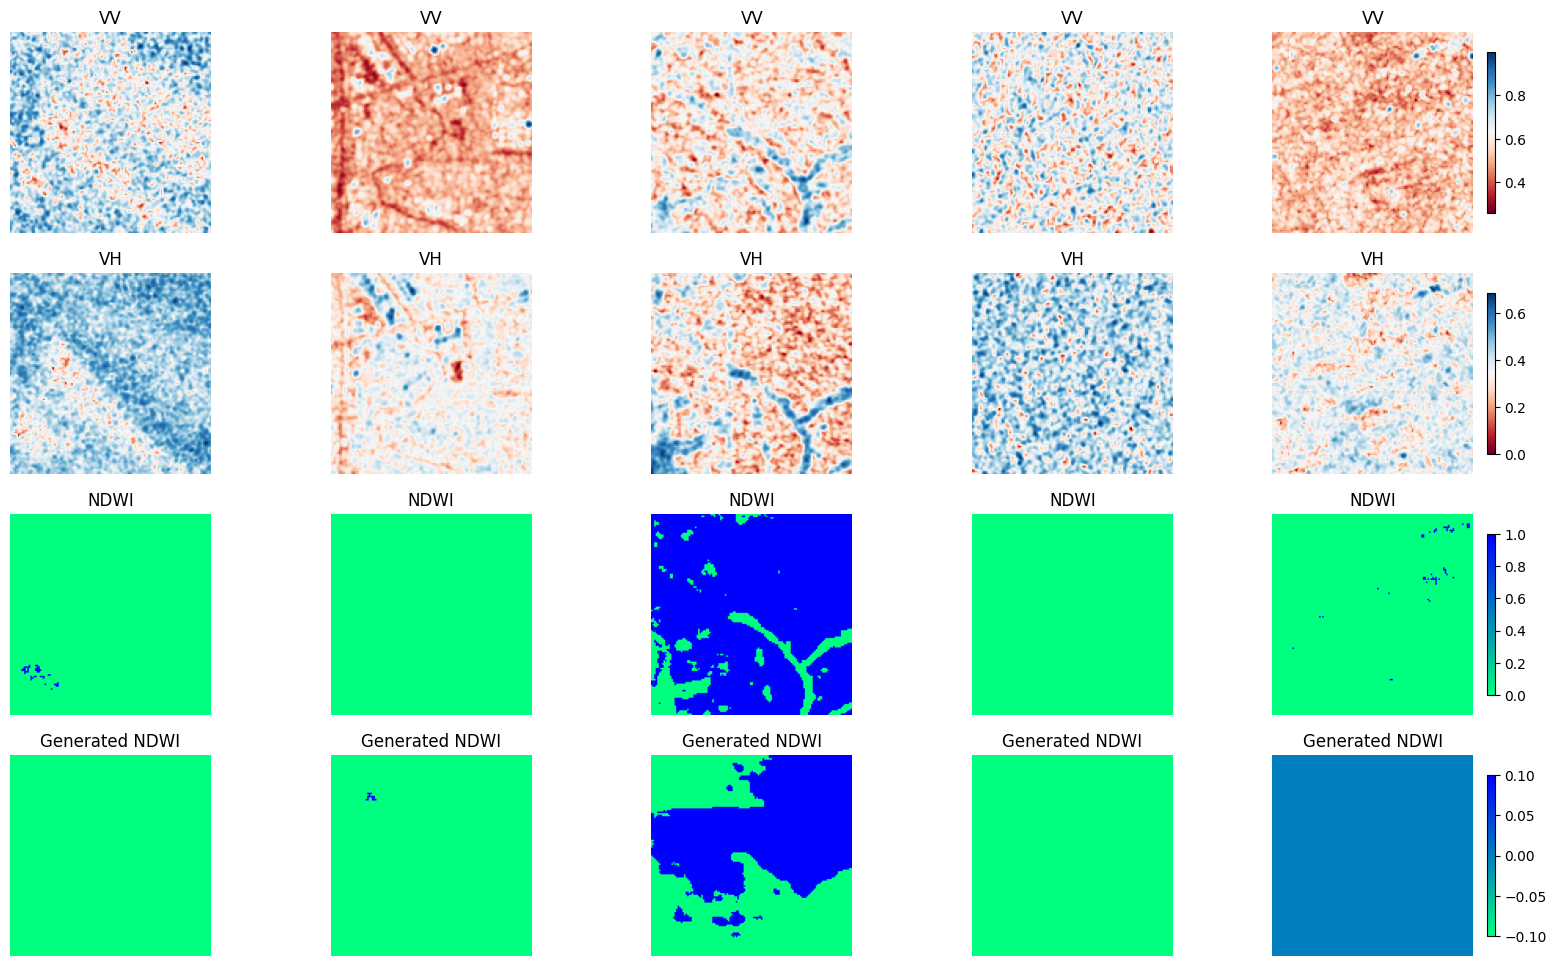

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=5,figsize=(20,12))
for i,j in enumerate(sample_idx):
    c1 = ax[0,i].imshow(scale(S1_test[j])[:,:,0],cmap="RdBu")
    c2 = ax[1,i].imshow(scale(S1_test[j])[:,:,1],cmap="RdBu")
    c3 = ax[2,i].imshow(S2_test[j],cmap="winter_r")
    c4 = ax[3,i].imshow(mask_out[i] > 0.8,cmap="winter_r")
    ax[0,i].set_title("VV")
    ax[1,i].set_title("VH")
    ax[2,i].set_title("NDWI")
    ax[3,i].set_title("Generated NDWI")
    ax[0,i].axis("off")
    ax[1,i].axis("off")
    ax[2,i].axis("off")
    ax[3,i].axis("off")
plt.colorbar(c1,ax = ax[0,4],shrink = 0.8)
plt.colorbar(c2,ax = ax[1,4],shrink = 0.8)
plt.colorbar(c3,ax = ax[2,4],shrink = 0.8)
plt.colorbar(c4,ax = ax[3,4],shrink = 0.8);
# fig.savefig(f"/content/drive/MyDrive/SrJ/Flood_Monitoring/CycleGAN2/Sample_Epoch100000_NoThresh.png")

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'r2_score', 'mean_io_u', 'val_loss', 'val_accuracy', 'val_auc', 'val_r2_score', 'val_mean_io_u'])

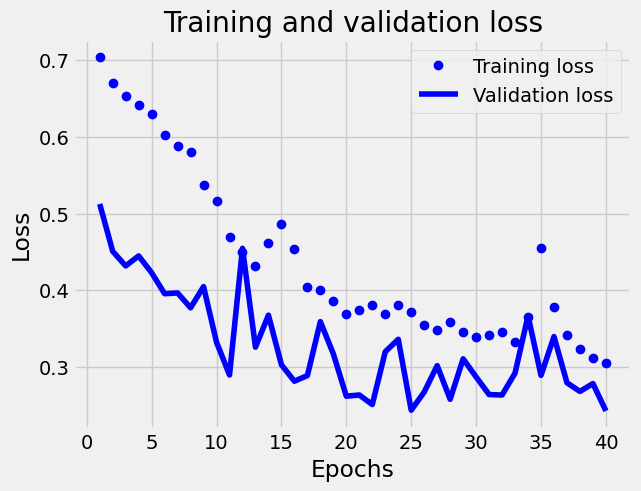

In [ ]:
# prompt: generate graph for loss and save it

import matplotlib.pyplot as plt

# Extract the loss values from the history dictionary
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(loss) + 1)

# Create the plot
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as a PNG image
plt.savefig('loss.png')



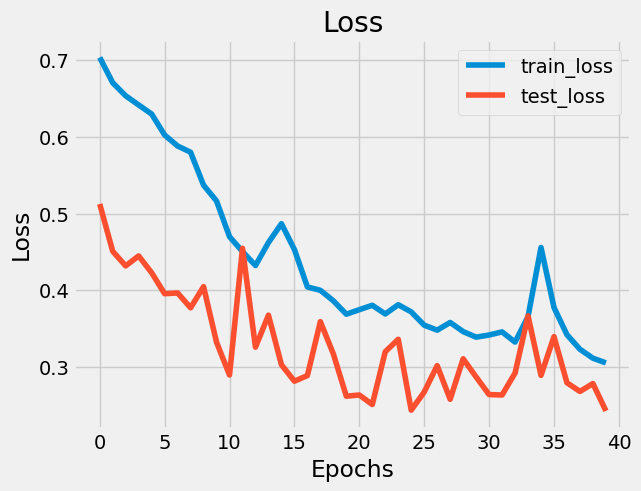

In [ ]:
plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train_loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='test_loss')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Save the plot as a PNG image
plt.savefig('loss.png')
plt.show()

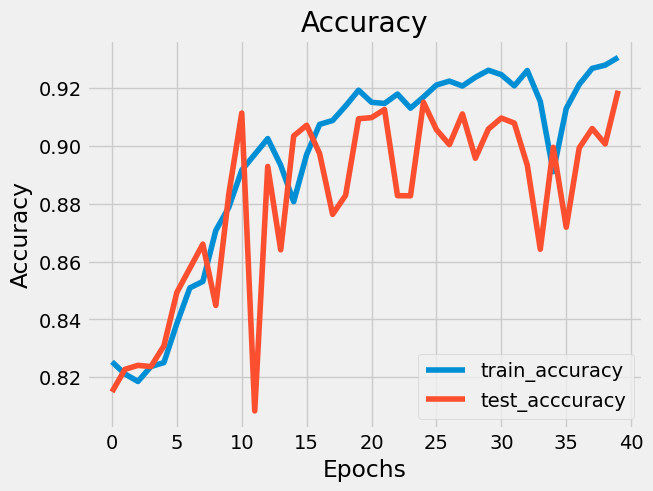

In [ ]:
plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train_accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='test_acccuracy')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Save the plot as a PNG image
plt.savefig('acc.png')
plt.show()

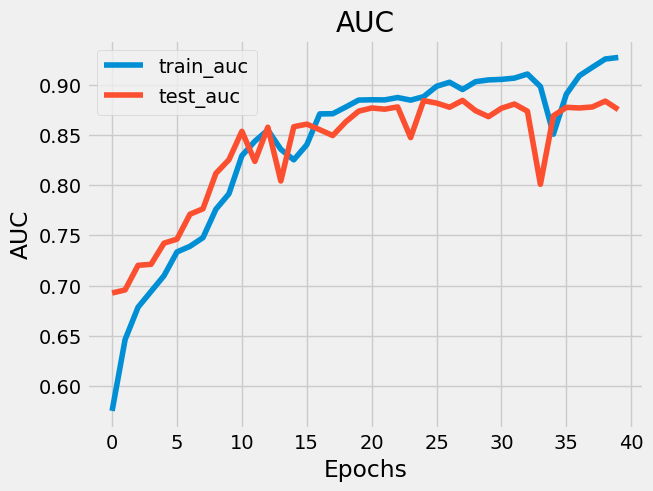

In [ ]:
plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['auc'], label='train_auc')
sns.lineplot(x=history.epoch, y=history.history['val_auc'], label='test_auc')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')

# Save the plot as a PNG image
plt.savefig('auc.png')
plt.show()

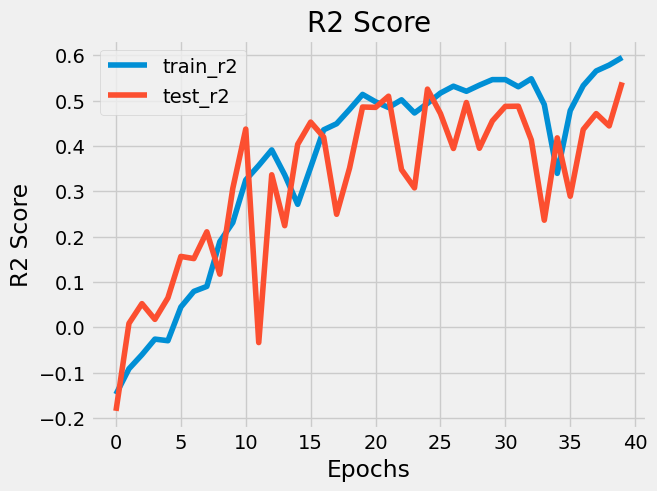

In [ ]:
# prompt: draw graph for r2 scores

plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['r2_score'], label='train_r2')
sns.lineplot(x=history.epoch, y=history.history['val_r2_score'], label='test_r2')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')

# Save the plot as a PNG image
plt.savefig('r2.png')
plt.show()


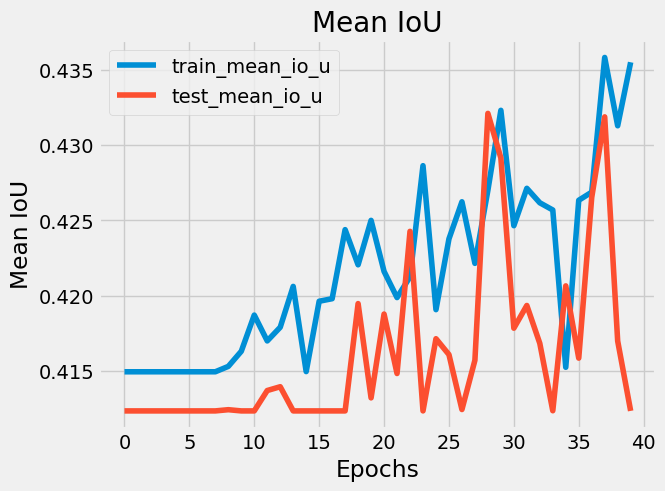

In [ ]:
# prompt: generate a graph for mean_io_u

plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['mean_io_u'], label='train_mean_io_u')
sns.lineplot(x=history.epoch, y=history.history['val_mean_io_u'], label='test_mean_io_u')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')

# Save the plot as a PNG image
plt.savefig('iou.png')
plt.show()


24/24 [==============================] - 3s 125ms/step


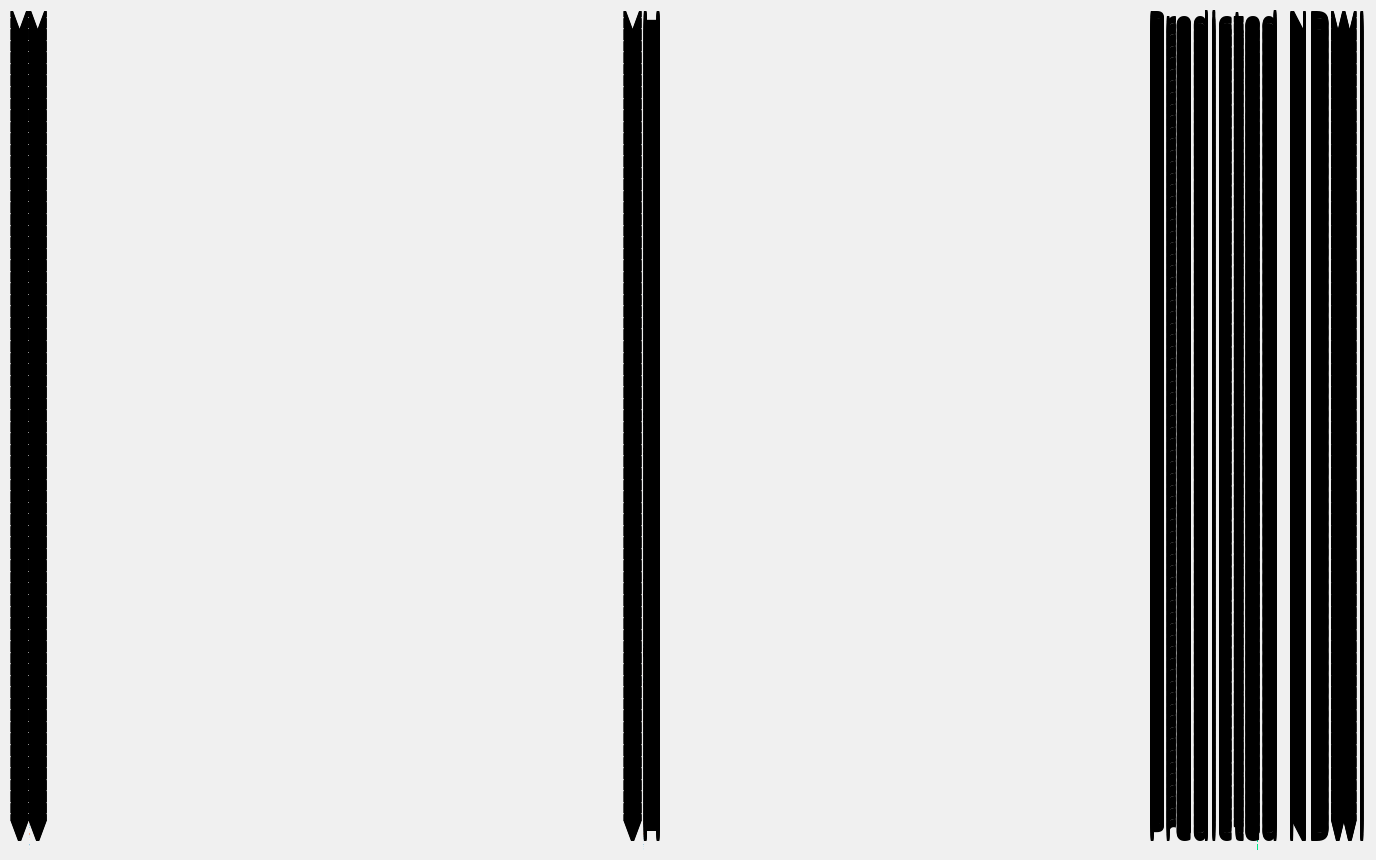

In [ ]:
# prompt: draw images for prediction of s1_cloud using the model and also draw the two images in S1_cloud

import matplotlib.pyplot as plt

# Load the model
# model = load_model("path/to/model.h5")

# Get the test images
# S1_cloud = np.array([tf.cast((img*2) - 1.0, tf.float32) for img in S1_cloud])

# Make predictions on the test images
S1_cloud_pred = unet_model.predict(S1_cloud)

# Draw the images
fig, ax = plt.subplots(ncols=3, nrows=len(S1_cloud), figsize=(20, 10))
for i in range(len(S1_cloud)):
    ax[i, 0].imshow(S1_cloud[i][:, :, 0], cmap="RdBu")
    ax[i, 0].set_title("VV")
    ax[i, 1].imshow(S1_cloud[i][:, :, 1], cmap="RdBu")
    ax[i, 1].set_title("VH")
    ax[i, 2].imshow(S1_cloud_pred[i], cmap="winter_r")
    ax[i, 2].set_title("Predicted NDWI")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

plt.show()


In [ ]:
# prompt: how to get the best model from unet

model_path = os.path.join(OUT_PATH, "U-Net", "best_model_unet.hdf5")
unet_model = tf.keras.models.load_model(model_path)


In [ ]:
from sklearn.metrics import